In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [10]:
df_train.shape

(7613, 5)

In [11]:
df_test.shape

(3263, 4)

In [12]:
df_train.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [13]:
df_train.keyword.value_counts().sort_values(ascending = False)

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [14]:
df_train["text_words"] = df_train.text.apply(lambda x: len(x.split()))
df_test["text_words"] = df_test.text.apply(lambda x: len(x.split()))

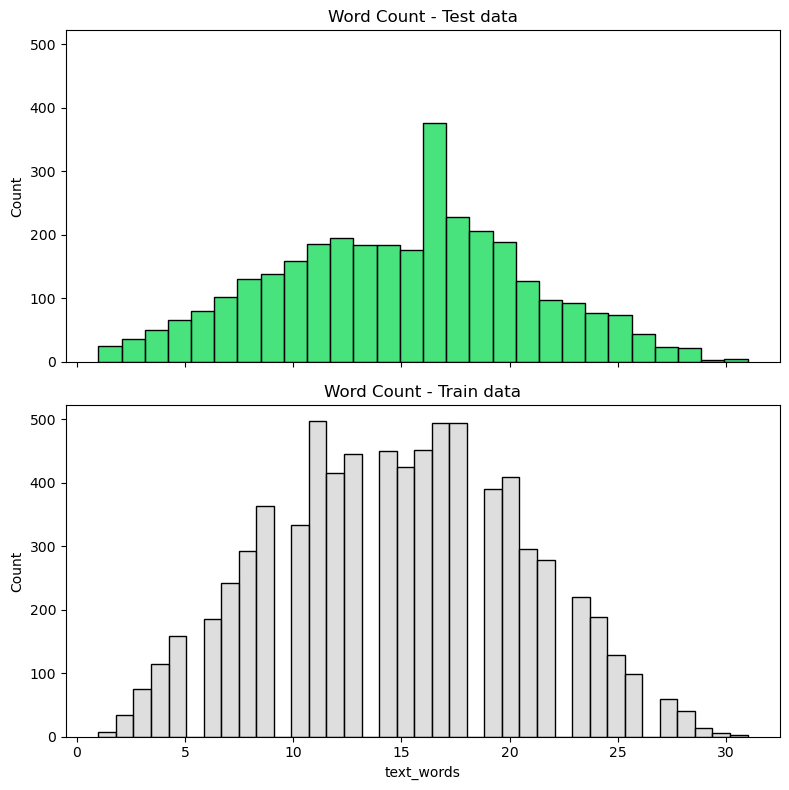

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)

sns.histplot(data=df_test, x=df_test['text_words'], color='#0BDA51', ax=axes[0]).set(title='Word Count - Test data')
sns.histplot(data=df_train, x=df_train['text_words'], color='#D3D3D3', ax=axes[1]).set(title='Word Count - Train data');

# Add a Super Title
#fig.suptitle('Distribution of Word Count by Dataset', ha='center')
#plt.savefig("Word_Count_data.png")

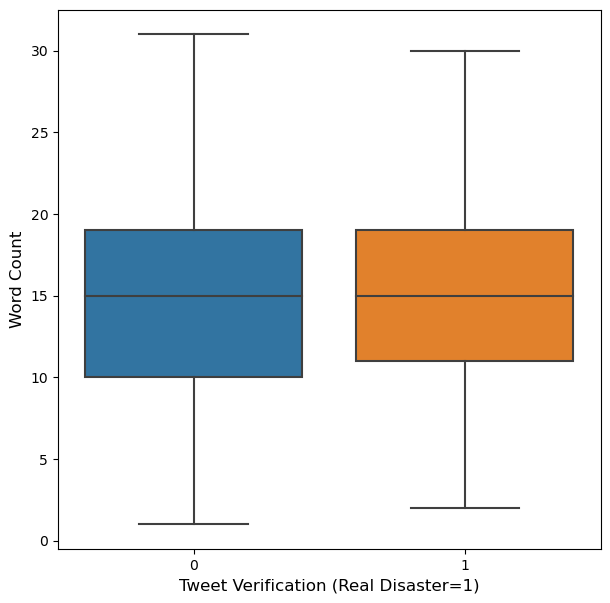

In [16]:
#df_train.boxplot(by ='target', column =['text_words'], grid = False);

plt.figure(figsize=(7,7))
word_count = sns.boxplot(x='target', y='text_words', data=df_train)
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Word Count', fontsize=12);

Note: the word count for 'real' and 'not real' disasters has a similar distribution, with a slightly shorter word count for 'not real' disasters

In [17]:
#word_count vs character_count
df_train['character_count'] = df_train['text'].str.len()
df_test['character_count'] = df_test['text'].str.len()

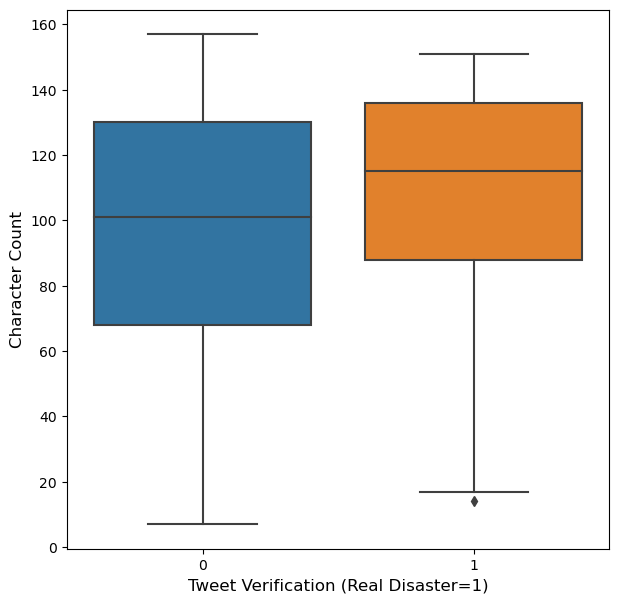

In [18]:
plt.figure(figsize=(7,7))
word_count = sns.boxplot(x='target', y='character_count', data=df_train)
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Character Count', fontsize=12);

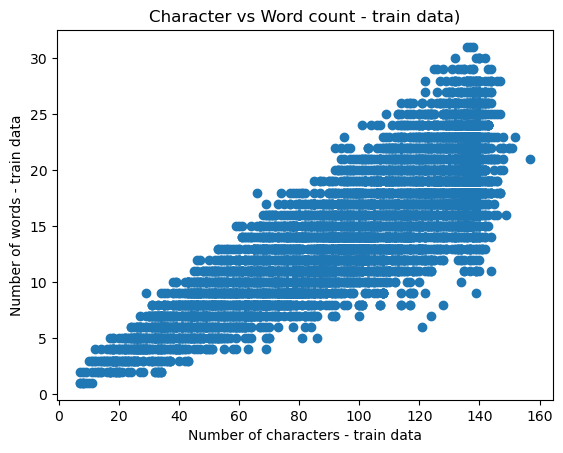

In [19]:
plt.scatter(df_train["character_count"], df_train["text_words"])

plt.xlabel("Number of characters - train data")
plt.ylabel("Number of words - train data")
plt.title("Character vs Word count - train data)")

plt.show()

In [20]:
df_train_target = df_train.groupby(['target']).aggregate({'character_count':'mean','text_words':'mean'})
df_train_target.reset_index()

,target,character_count,text_words
0,0,95.706817,14.704744
1,1,108.113421,15.167533


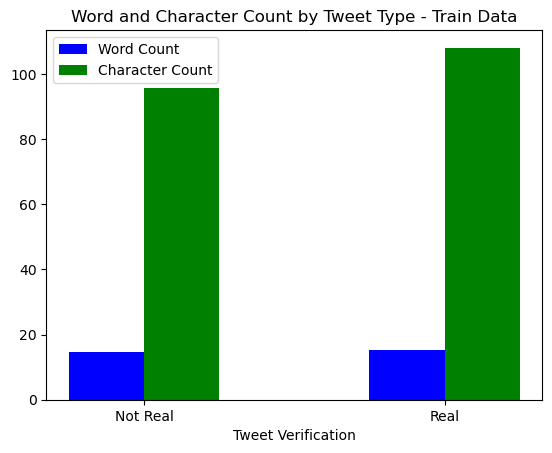

In [21]:
plt.bar(np.arange(2), df_train_target['text_words'], color = 'b',
        width = 0.25,
        label='Word Count')
plt.bar(np.arange(2)+.25, df_train_target["character_count"], color = 'g',
        width = 0.25,
        label='Character Count')
  
plt.xlabel("Tweet Verification")
plt.title("Word and Character Count by Tweet Type - Train Data")

plt.xticks(np.arange(2)+.25/2,['Not Real', 'Real'])
plt.legend()

  
plt.show()

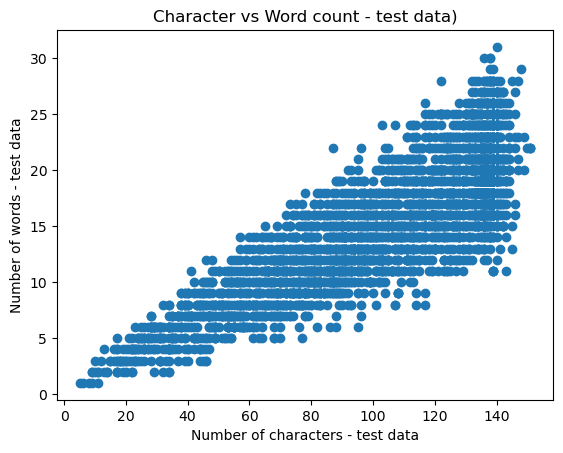

In [22]:
plt.scatter(df_test["character_count"], df_test["text_words"])

plt.xlabel("Number of characters - test data")
plt.ylabel("Number of words - test data")
plt.title("Character vs Word count - test data)")

plt.show()

In [23]:
filtered_df_train = df_train.dropna(subset = ['keyword'])

#df_train['count_keyword'] = df_train.apply(lambda x: x['text'].count(x['keyword']), axis=1)
filtered_df_train['count_keyword'] = [x.text.count(x.keyword) for x in filtered_df_train.itertuples()]

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_50562/1697830117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_train['count_keyword'] = [x.text.count(x.keyword) for x in filtered_df_train.itertuples()]


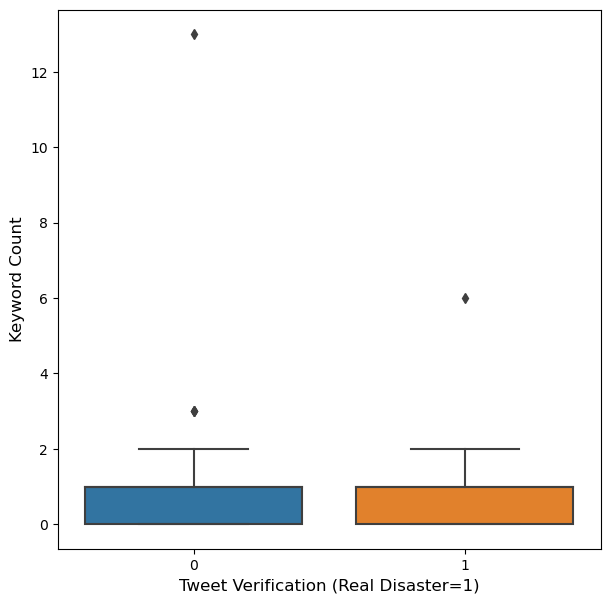

In [24]:
plt.figure(figsize=(7,7))
keyword_count = sns.boxplot(x='target', y='count_keyword', data=filtered_df_train)
plt.xlabel('Tweet Verification (Real Disaster=1)', fontsize=12)
plt.ylabel('Keyword Count', fontsize=12);

Note: Consider removing tweets where keyword count exceeds 2 per tweet

### Model

#### Lemmatize

In [25]:
from nltk.stem import WordNetLemmatizer
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    x = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return(" ".join(x))

df_train['text_lemmatized'] = df_train.text.apply(lemmatize_text)

In [26]:
X = df_train["text_lemmatized"]
y = df_train["target"]

In [27]:
X_train, X_traintest, y_train, y_traintest = train_test_split(X,
                                                    y,
                                                    random_state=42)

#### Bernoulli

**Count Vector**

In [28]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [29]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [30]:
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [31]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [32]:
gs.best_score_

0.7959371369017562

In [33]:
print(gs.score(X_train,y_train))
print(gs.score(X_traintest,y_traintest))

0.8637239446488001
0.8046218487394958


**TFIDF**

In [34]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [35]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [36]:
gs_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [37]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [38]:
gs_tvec.best_score_

0.7959371369017562

In [39]:
print(gs_tvec.score(X_train,y_train))
print(gs_tvec.score(X_traintest,y_traintest))

0.8637239446488001
0.8046218487394958


#### Logistic Regression

**Count Vector**

In [40]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [41]:
gs_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [42]:
gs_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [43]:
gs_logr.best_score_

0.7903303244304394

In [44]:
print(gs_logr.score(X_train,y_train))
print(gs_logr.score(X_traintest,y_traintest))

0.8935014888772114
0.8014705882352942


**TFIDF**

In [45]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [46]:
gs_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                pipe_params_tvec, 
                  cv = 5)

In [47]:
gs_tvec_logr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [48]:
gs_tvec_logr.best_score_

0.7880536168997914

In [49]:
print(gs_tvec_logr.score(X_train,y_train))
print(gs_tvec_logr.score(X_traintest,y_traintest))

0.8999824837975127
0.7967436974789915


#### ADA Boost + Logistic Regression

In [50]:
abc = AdaBoostClassifier(random_state = 42)

In [51]:
cv = CountVectorizer(min_df=2)
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_traintest)

In [52]:
dt_abc = abc.fit(X_train_cv, y_train)

In [53]:
print(dt_abc.score(X_train_cv, y_train))
print(dt_abc.score(X_test_cv, y_traintest))

0.7708880714661062
0.7473739495798319


#### Decision Tree

In [54]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [55]:
dtc = DecisionTreeClassifier()

In [56]:
dt = dtc.fit(X_train_cv, y_train)

In [58]:
print(dt.score(X_train_cv, y_train))
print(dt.score(X_test_cv, y_traintest))

0.9872131721842704
0.7289915966386554


In [60]:
tv = TfidfVectorizer(min_df=2)
tv.fit(X_train)

X_train_tv = tv.transform(X_train)
X_test_tv = tv.transform(X_traintest)

In [61]:
dt_tvec = dtc.fit(X_train_tv, y_train)

In [62]:
print(dt.score(X_train_tv, y_train))
print(dt.score(X_test_tv, y_traintest))

0.9872131721842704
0.6959033613445378


## Stopwords

In [89]:
df_train

,id,keyword,location,text,target,text_words,character_count,text_lemmatized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All resident asked to 'shelter in place' are b...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby #Alaska a s...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,83,Two giant crane holding a bridge collapse into...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,125,@aria_ahrary @TheTawniest The out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,65,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,137,Police investigating after an e-bike collided ...


In [93]:
%pip install pandas emoji

  Obtaining dependency information for emoji from https://files.pythonhosted.org/packages/96/c6/0114b2040a96561fd1b44c75df749bbd3c898bf8047fb5ce8d7590d2dee6/emoji-2.8.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 3.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [94]:
import emoji
import re

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [135]:
stopwords = nltk.corpus.stopwords.words('english')
new_stop_words = ["ha", "wa", "http", "s", "https", "com", "'s", "' s", "'ll", "' ll", "' d", "'d", "'re", "' re", "-LRB-", '-RRB-', "co", "amp", "url"]
stopwords.extend(new_stop_words)

In [136]:
df_train["tweet_1"] = df_train["text_lemmatized"].replace("\\n"," ").replace("\t"," ").replace("<u+", "")

In [137]:
df_train["tweet_2"] = df_train["tweet_1"].replace("[^0-9a-zA-Z]#@+","")

In [138]:
df_train["tweet_3"] = [remove_emojis(x) for x in df_train["tweet_2"]]

In [139]:
df_train["tweet_4"] = df_train["tweet_3"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stopwords))

In [140]:
df_train["tweet_5"] = df_train["tweet_4"].str.replace('((www\.[\s]+)|(https?://[^\s]+))','<URL>',regex=True)

In [141]:
remove = "..;'()ûò,&=!?-:|[]ã¢+ªóï*<>"
for char in remove:
    df_train["tweet_5"] =  df_train["tweet_5"].str.replace(char,'', regex=False)
    
to_space = "/åê"
for char in to_space:
     df_train["tweet_5"] =  df_train["tweet_5"].str.replace(char,'', regex=False)

In [142]:
Xn = df_train["tweet_5"]
y = df_train["target"]

In [143]:
cvec_lemm = CountVectorizer(stop_words=stopwords)
cvec_lemm.fit(Xn)
cvec_lemm_data = cvec_lemm.transform(Xn)
df_lemm = pd.DataFrame(cvec_lemm_data.todense(), columns=cvec_lemm.get_feature_names_out())

/Users/polinaminkovski/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lrb', 'rrb'] not in stop_words.
  warnings.warn(


In [144]:
df_lemm_ = pd.merge(df_lemm, y, left_index=True, right_index=True)
df_lemm_.head()

,0011,001116,0025,005225,010156,010217,0104,010401,0106,0111,...,zumiez,zurich,zxathetis,zzzz,ââ,èmgnafrica,ìñ,ìñ1,ìü,target_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [145]:
df_lemm_.drop(columns=["target_x"])

,0011,001116,0025,005225,010156,010217,0104,010401,0106,0111,...,zumiez,zurich,zxathetis,zzzz,ââ,èmgnafrica,ìñ,ìñ1,ìü,target_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7610,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


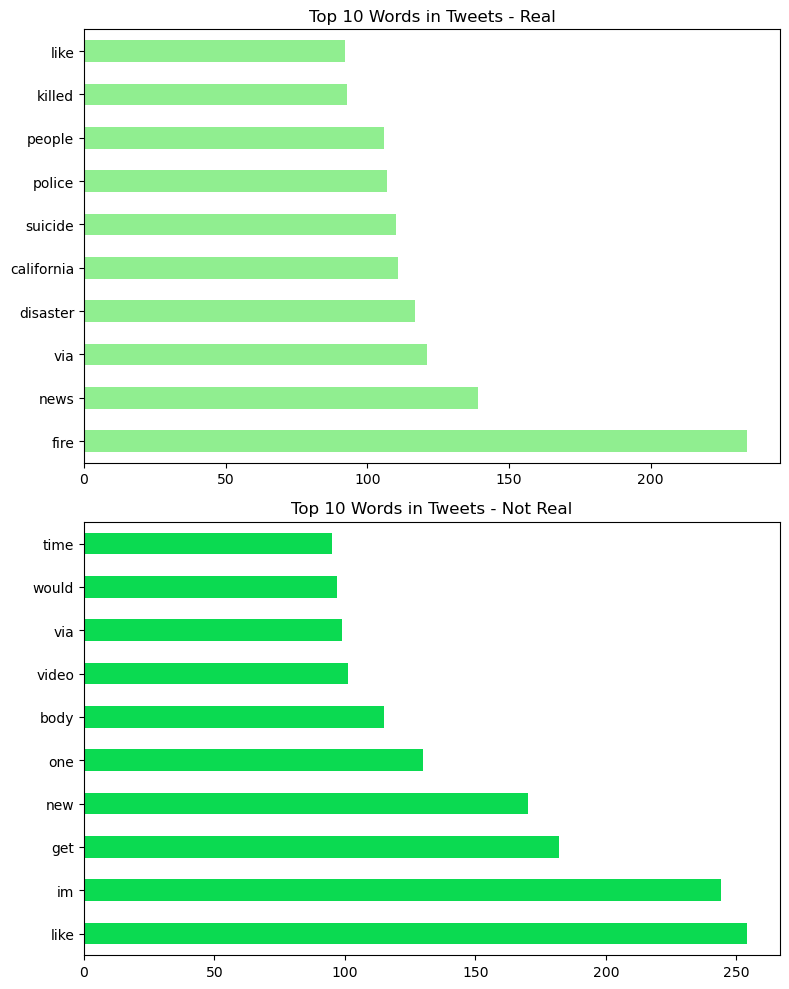

In [146]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10), tight_layout=True)

(df_lemm_[df_lemm_['target_y'] == 1]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words in Tweets - Real', color='#90EE90', ax=axes[0]));

(df_lemm_[df_lemm_['target_y'] == 0]
    .drop(columns=['target_y'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words in Tweets - Not Real', color='#0BDA51', ax=axes[1]));

In [148]:
Xn_train, Xn_traintest, y_train, y_traintest = train_test_split(Xn,
                                                    y,
                                                    random_state=42, stratify=y)

#### Bernoulli

**Count Vector**

In [149]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [150]:
pipe_params = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : ['english'],
}

In [151]:
gs_n = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [152]:
gs_n.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [153]:
gs_n.best_score_

0.7947106035047757

In [154]:
print(gs_n.score(Xn_train,y_train))
print(gs_n.score(Xn_traintest,y_traintest))

0.8665265370467683
0.8051470588235294


**TFIDF**

In [155]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : ['english']
}

In [156]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [159]:
gs_n_tvec = GridSearchCV(pipe_tvec, 
                  pipe_params_tvec, 
                  cv = 5)

In [160]:
gs_n_tvec.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [161]:
gs_n_tvec.best_score_

0.7947106035047757

In [162]:
print(gs_n_tvec.score(Xn_train,y_train))
print(gs_n_tvec.score(Xn_traintest,y_traintest))

0.8665265370467683
0.8051470588235294


#### Logistic Regression

**Count Vector**

In [165]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [166]:
gs_n_logr = GridSearchCV(pipe_logr, 
                  pipe_params, 
                  cv = 5)

In [167]:
gs_n_logr.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': ['english']})

In [168]:
gs_n_logr.best_score_

0.7922596855617172

In [169]:
print(gs_n_logr.score(Xn_train,y_train))
print(gs_n_logr.score(Xn_traintest,y_traintest))

0.8915747066036084
0.8046218487394958


**TFIDF**

In [170]:
pipe_tvec_logr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [171]:
gs_n_tvec_logr = GridSearchCV(pipe_tvec_logr, 
                pipe_params_tvec, 
                  cv = 5)

In [172]:
gs_n_tvec_logr.fit(Xn_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': ['english']})

In [173]:
gs_n_tvec_logr.best_score_

0.7828013648273014

In [174]:
print(gs_n_tvec_logr.score(Xn_train,y_train))
print(gs_n_tvec_logr.score(Xn_traintest,y_traintest))

0.906113154668068
0.8019957983193278


#### ADA Boost + Logistic Regression

In [175]:
abc = AdaBoostClassifier(random_state = 42)

In [176]:
cv = CountVectorizer(min_df=2)
cv.fit(Xn_train)

Xn_train_cv = cv.transform(Xn_train)
Xn_test_cv = cv.transform(Xn_traintest)

In [177]:
dt_abc_n = abc.fit(Xn_train_cv, y_train)

In [178]:
print(dt_abc_n.score(Xn_train_cv, y_train))
print(dt_abc_n.score(Xn_test_cv, y_traintest))

0.7556489753021545
0.7389705882352942


#### Decision Tree

In [54]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [55]:
dtc = DecisionTreeClassifier()

In [179]:
dt_n = dtc.fit(Xn_train_cv, y_train)

In [180]:
print(dt_n.score(Xn_train_cv, y_train))
print(dt_n.score(Xn_test_cv, y_traintest))

0.9872131721842704
0.7563025210084033


In [181]:
tv = TfidfVectorizer(min_df=2)
tv.fit(Xn_train)

Xn_train_tv = tv.transform(Xn_train)
Xn_test_tv = tv.transform(Xn_traintest)

In [182]:
dt_n_tvec = dtc.fit(Xn_train_tv, y_train)

In [183]:
print(dt_n_tvec.score(Xn_train_tv, y_train))
print(dt_n_tvec.score(Xn_test_tv, y_traintest))

0.9872131721842704
0.7242647058823529


#### Random Forest

In [185]:
rf = RandomForestClassifier()

In [186]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_n = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_n.fit(Xn_train_cv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [188]:
print(gs_dt_n.score(Xn_train_cv,y_train))
print(gs_dt_n.score(Xn_test_cv,y_traintest))

0.9872131721842704
0.7925420168067226


In [189]:
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [None, 3, 4, 5, 6, 7]
}
gs_dt_tvec_n = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
gs_dt_tvec_n.fit(Xn_train_tv, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5, 6, 7],
                         'n_estimators': [100, 150, 200]})

In [190]:
print(gs_dt_tvec_n.score(Xn_train_tv,y_train))
print(gs_dt_tvec_n.score(Xn_test_tv,y_traintest))

0.9872131721842704
0.7977941176470589


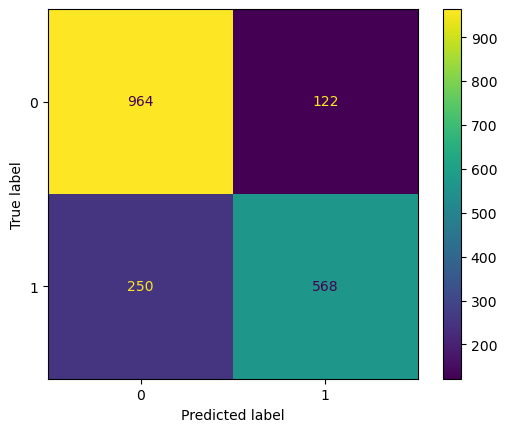

In [192]:
preds = gs_n_logr.predict(Xn_traintest)

cm = confusion_matrix(y_traintest, preds, labels=gs_n_logr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gs_n_logr.classes_)
disp.plot();